<a href="https://colab.research.google.com/github/angelohafner/linguagem-de-programacao-udesc/blob/main/iec_inverse_curves.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
import numpy as np
import matplotlib.pyplot as plt

def get_iec_params(curve_type):
    """
    Return IEC 60255 parameters (A, B) for a given curve type.

    curve_type options (strings, case-insensitive):
    - "NI" : Normal Inverse
    - "MI" : Very/Moderately Inverse (IEC type)
    - "EI" : Extremely Inverse
    """
    ct = curve_type.upper()
    if ct == "NI":
        # Normal Inverse
        A = 0.14
        B = 0.02
    elif ct == "MI":
        # IEC Very/Moderately Inverse
        A = 13.5
        B = 1.0
    elif ct == "EI":
        # Extremely Inverse
        A = 80.0
        B = 2.0
    else:
        raise ValueError("Unsupported curve_type. Use 'NI', 'MI' or 'EI'.")
    return A, B


def iec_time(I_over_Iref, k, A, B, eps=1e-6):
    """
    Compute IEC inverse-time for given ratio I/Ip, time multiplier k,
    and constants A, B according to IEC 60255.
    """
    ratio = np.array(I_over_Iref, dtype=float)
    ratio = np.where(ratio <= 1.0 + eps, 1.0 + eps, ratio)
    t = k * A / (np.power(ratio, B) - 1.0)
    return t


def plot_iec_inverse_with_tcc(Iref_list, k_list, Icc_list, tcc_list,
                              curve_type="NI", n_points=400):
    """
    Plot IEC inverse-time curves with definite-time elements.

    Features:
    - Inverse-time curves limited between 1.05*Iref[i] and Icc[i]
    - Vertical definite-time segments at Icc[i]
    - Horizontal definite-time segments from Icc[i] to global max x

    All curves share the same global x-axis:
    x in [1.05 * min(Iref_list), 1.1 * max(Icc_list)]

    curve_type: "NI", "MI" or "EI" (IEC 60255 families)
    """

    # Convert inputs to numpy arrays
    Iref = np.array(Iref_list, dtype=float)
    k    = np.array(k_list,    dtype=float)
    Icc  = np.array(Icc_list,  dtype=float)
    tcc  = np.array(tcc_list,  dtype=float)

    # Size checks
    if not (Iref.size == k.size == Icc.size == tcc.size):
        raise ValueError("All input lists must have the same length.")

    n_curves = Iref.size
    eps = 1e-6

    # IEC parameters for selected curve type
    A, B = get_iec_params(curve_type)

    # Global x-axis limits
    x_min_global = 1.05 * np.min(Iref)
    x_max_global = 1.1 * np.max(Icc)

    # Common x vector for plotting (linear sampling, log effect via axis scale if needed)
    I_full = np.linspace(x_min_global, x_max_global, n_points)

    plt.figure(figsize=(6.30, 10.12))

    for i in range(n_curves):

        # Minimum current to start curve (1.05 * pickup)
        I_min_curve = 1.05 * Iref[i]

        # Effective short-circuit point for cutting the curve (never below I_min_curve)
        Icc_effective = max(Icc[i], I_min_curve)

        # Ratio I / Iref for this curve on global x grid
        ratio_full = I_full / Iref[i]

        # Full IEC inverse-time curve on the global grid
        t_full = iec_time(ratio_full, k[i], A, B, eps=eps)

        # Time on inverse-time curve at Icc_effective
        ratio_icc_eff = Icc_effective / Iref[i]
        t_curve_icc_eff = iec_time(ratio_icc_eff, k[i], A, B, eps=eps)

        # Mask: show curve only between 1.05*Iref[i] and Icc_effective
        mask = (I_full >= I_min_curve) & (I_full <= Icc_effective)
        I_cut = I_full[mask]
        t_cut = t_full[mask]

        # Ensure meeting point (Icc_effective, t_curve_icc_eff) is included
        if I_cut.size == 0 or I_cut[-1] < Icc_effective:
            I_cut = np.append(I_cut, Icc_effective)
            t_cut = np.append(t_cut, t_curve_icc_eff)

        # Legend with Iref, Icc, tcc, k, curve_type
        label_curve = (
            f"{curve_type.upper()} | "
            f"Iref={Iref[i]:.1f} A, "
            f"Icc={Icc[i]:.1f} A, "
            f"tcc={tcc[i]:.3g} s, "
            f"k={k[i]:.3f}"
        )

        # Plot inverse-time curve
        line_obj, = plt.plot(I_cut, t_cut, label=label_curve)

        # Same style for definite-time segments
        curve_color = line_obj.get_color()
        curve_style = line_obj.get_linestyle()

        # Vertical definite-time line (from tcc to curve meeting point)
        plt.plot([Icc[i], Icc[i]],
                 [tcc[i], t_curve_icc_eff],
                 color=curve_color,
                 linestyle=curve_style)

        # Horizontal definite-time line from Icc[i] to x_max_global
        plt.plot([Icc[i], x_max_global],
                 [tcc[i], tcc[i]],
                 color=curve_color,
                 linestyle=curve_style)

    plt.xlabel("$I$ [A]")
    plt.ylabel("$t$ [s]")
    plt.title(f"IEC 60255 – {curve_type.upper()} Inverse with Definite-Time Segments")

    # y-axis in log scale (x-axis linear)
    # plt.xscale("log")  # keep commented as in your last version
    plt.yscale("log")

    # Minor ticks ON for both axes (to enable minor grid)
    plt.minorticks_on()

    # ----- GRID STYLE -----
    plt.grid(which="major", linestyle="--", linewidth=0.8, color="black")
    plt.grid(which="minor", linestyle="--", linewidth=0.5, color="gray")

    plt.legend()
    plt.tight_layout()
    plt.show()

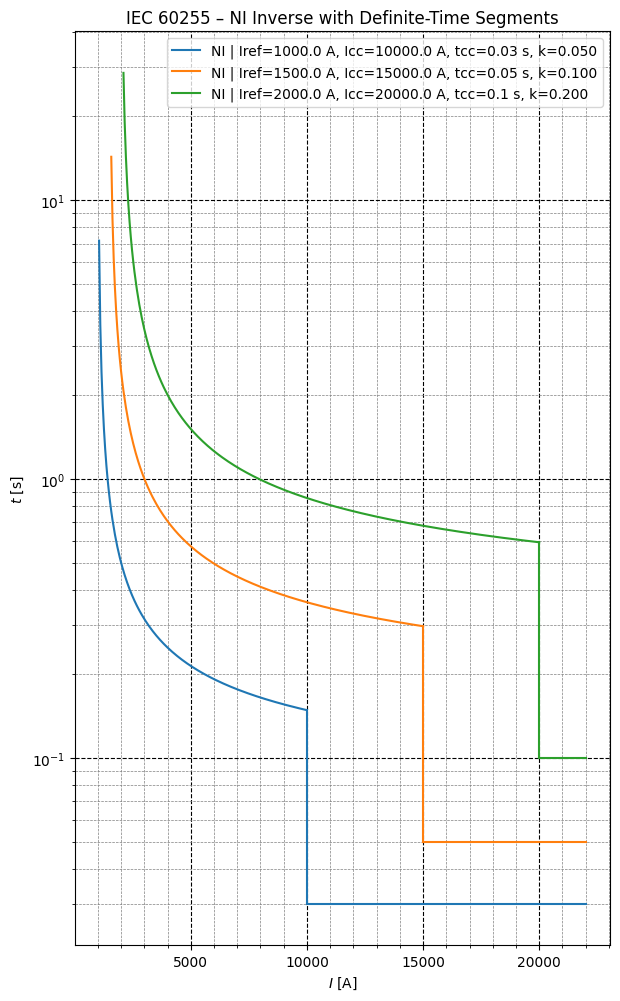

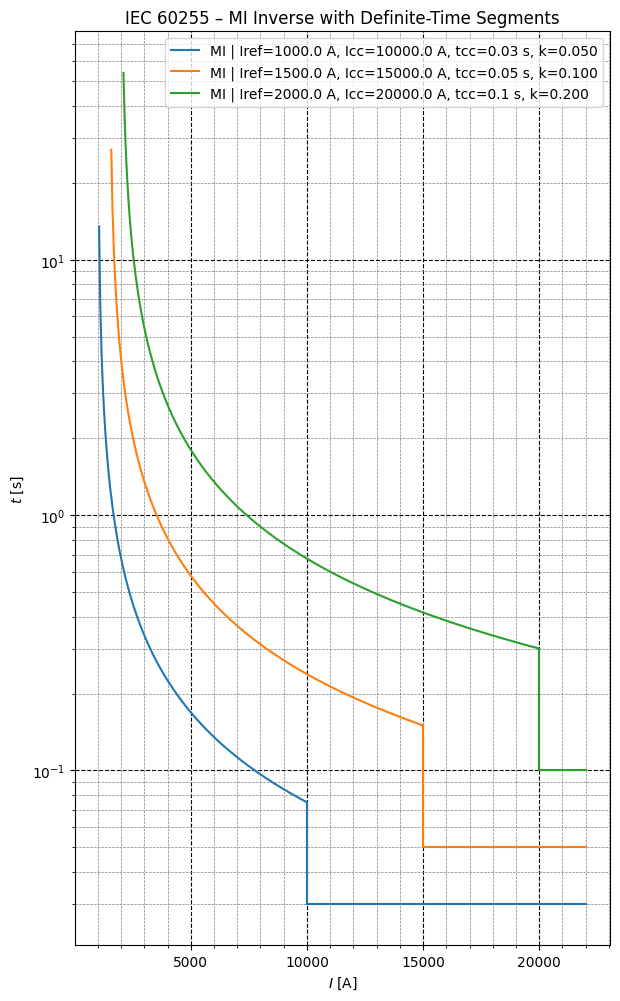

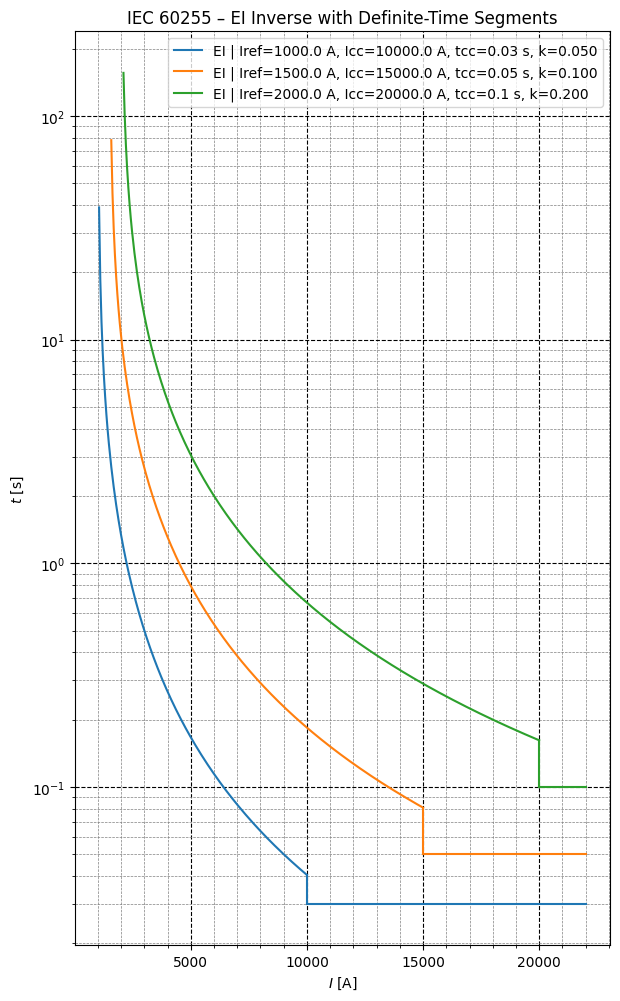

In [39]:
# ----------------- EXAMPLE -----------------
Iref_example = [1000.0, 1500.0, 2000.0]
k_example    = [0.05,   0.10,   0.20  ]
Icc_example  = [10000.0, 15000.0, 20000.0]
tcc_example  = [3e-2,    5e-2,    1e-1   ]

# Normal Inverse
plot_iec_inverse_with_tcc(
    Iref_example, k_example, Icc_example, tcc_example,
    curve_type="NI"
)

# Moderately / Very Inverse (IEC MI)
plot_iec_inverse_with_tcc(
    Iref_example, k_example, Icc_example, tcc_example,
    curve_type="MI"
)

# Extremely Inverse (IEC EI)
plot_iec_inverse_with_tcc(
    Iref_example, k_example, Icc_example, tcc_example,
    curve_type="EI"
)